In [1]:
import requests
import csv
import json
import random
from time import sleep
from collections import Counter

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("csv/kijiji_listing_data.csv")
del df["Unnamed: 0"]
# del df["url"]
df = df[df['cost'] != -1]
df = df[df['size'] > 1]
# df = df[df['agreement'] != "Not Available"]
df = df[df['size'] != 12345] 
df = df[df['size'] != 9999] # (some idiots...)
df = df[df['parking'] != "Not Available"]

df["parking"] = df["parking"].apply(lambda s: int(s.rstrip('+')))

df["appliances"] = df["appliances"].apply(lambda s: s.split(','))
df["amenities"] = df["amenities"].apply(lambda s: s.split(','))
df["outdoor"] = df["outdoor"].apply(lambda s: s.split(','))

df["has_den"] = df["bedrooms"].str.endswith(" + Den").astype(int)
df["bedrooms"] = df["bedrooms"].apply(lambda s: 1 if s == "Bachelor/Studio" else int(s.rstrip(" + Den+")))

df = df.drop(df[(df['cost'] / df['size']) == (df['cost'] / df['size']).max()].index)

df

,cost,address,unitType,bedrooms,bathrooms,hydro,heat,water,wifi_info,parking,...,pet,size,furnished,appliances,ac,outdoor,smoking,amenities,url,has_den
0,933,"22-41 Munroe Pl., Regina, SK, S4S 6A7",Apartment,2,1.0,0,1,1,Cable / TV,1,...,1,860,0,"[Laundry (In Building), Fridge / Freezer]",1,[Balcony],1,"[24 Hour Security, Storage Space]",/v-apartments-condos/regina/2-bedroom-22-41-mu...,0
1,850,"2175 Rae Street, Regina, SK, S4T 2E8",Apartment,1,1.0,0,1,1,Not Included,0,...,1,380,0,"[Laundry (In Building), Fridge / Freezer]",1,[Not Included],0,[Not Included],/v-apartments-condos/regina/beautiful-bachelor...,0
2,799,"1424 Victoria Ave, Regina, SK, S4P 0P3",Apartment,1,1.0,0,1,1,Not Included,0,...,1,520,0,[Fridge / Freezer],0,[Not Included],0,[Not Included],/v-apartments-condos/regina/downtown-apartment...,0
3,814,"3864 Rae Street, Regina, SK, S4S 3A1",Apartment,1,1.0,0,1,1,Not Included,0,...,1,675,0,[Fridge / Freezer],0,[Not Included],0,[Not Included],/v-apartments-condos/regina/parliament-place-a...,0
4,1030,"2240 Robinson Street, Regina, SK, S4T 2P9",Apartment,2,1.0,0,1,1,Not Included,0,...,1,870,0,"[Laundry (In Building), Fridge / Freezer]",1,[Not Included],0,[Not Included],/v-apartments-condos/regina/pet-friendly-2-bed...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,1100,"125 Froom Crescent, Regina, SK S4N 1S8, Canada",Condo,2,1.0,0,1,1,Not Included,1,...,0,1000,1,"[Laundry (In Building), Dishwasher, Fridge / F...",1,[Not Included],0,"[Bicycle Parking, Storage Space]",/v-apartments-condos/regina/furnished-2-bedroo...,0
845,1095,", S4r2l7, Regina, SK",Apartment,2,1.0,0,1,1,Not Included,2,...,0,1000,0,"[Laundry (In Unit), Dishwasher, Fridge / Freezer]",1,[Yard],0,[Not Included],/v-apartments-condos/regina/clean-quiet-and-af...,0
847,895,"309 Belfast St, North Portal, SK S0C 1W0, Canada",House,2,1.0,0,0,1,Not Included,3,...,1,1300,0,"[Laundry (In Unit), Dishwasher, Fridge / Freezer]",0,[Yard],0,[Not Included],/v-apartments-condos/regina/house-for-rent/156...,1
849,1750,"Trinity Way, Regina, SK S0G 4G0, Canada",Condo,2,2.0,0,0,0,Not Included,2,...,1,1400,0,"[Laundry (In Unit), Dishwasher, Fridge / Freezer]",1,[Balcony],0,[Elevator in Building],/v-apartments-condos/regina/luxury-harbour-lan...,0


In [29]:
df[(df['cost'] / df['size']) == (df['cost'] / df['size']).max()].url.iloc[0]
# (df['cost'] / df['size']).nlargest(10)

'/v-apartments-condos/regina/room-available-for-rent-for-450-00/1569956247'

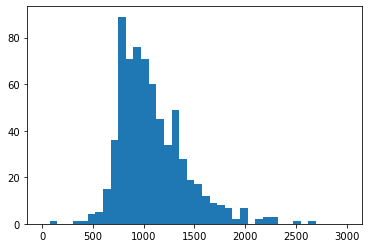

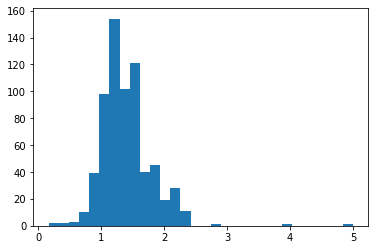

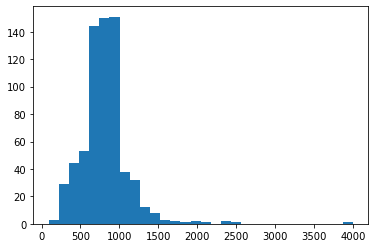

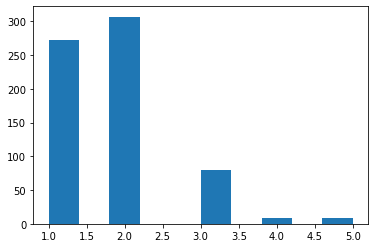

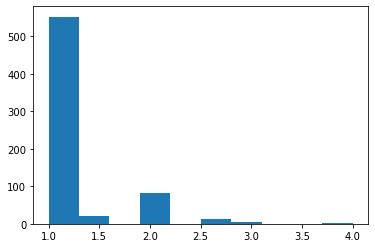

In [30]:
plt.hist(df['cost'], 40, (0, 3000)); plt.show();
plt.hist(df['cost'] / df['size'], 30); plt.show();
plt.hist(df['size'], 30); plt.show();
plt.hist(df['bedrooms']); plt.show();
plt.hist(df['bathrooms']);

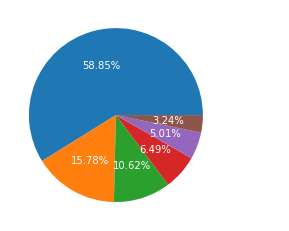

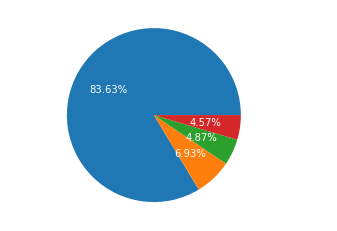

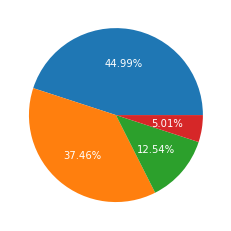

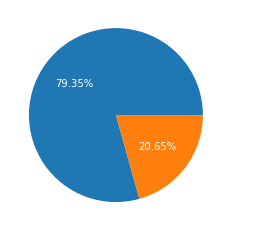

In [4]:
def piePlot(srs):
    keys, vals = zip(*Counter(srs).most_common())
    plt.pie(vals, labels=keys, autopct='%1.2f%%', textprops=dict(color='w'))
    plt.show()
doPie = ("unitType", "wifi_info", "parking", "agreement")
for col in doPie:
    piePlot(df[col])

In [5]:
for col in ("hydro", "heat", "water", "pet", "ac", "smoking"):
    print(f"{col}: {sum(df[col])/len(df)*100:2.2f}%")

hydro: 16.08%
heat: 69.32%
water: 77.58%
pet: 55.90%
ac: 50.88%
smoking: 9.44%


In [6]:
# Do appliances and amenities
print("Possible appliances:")
for item in set(item for lst in df["appliances"] for item in lst):
    print(f"- {item} ({df['appliances'].apply(lambda st: item in st).value_counts()[True] / len(df) * 100:2.2f}%)")
print("\nPossible amenities:")
for item in set(item for lst in df["amenities"] for item in lst):
    print(f"- {item} ({df['amenities'].apply(lambda st: item in st).value_counts()[True] / len(df) * 100:2.2f}%)")
print("\nPossible outdoors:")
for item in set(item for lst in df["outdoor"] for item in lst):
    print(f"- {item} ({df['outdoor'].apply(lambda st: item in st).value_counts()[True] / len(df) * 100:2.2f}%)")

Possible appliances:
- Dishwasher (35.10%)
- Not Included (1.33%)
- Laundry (In Building) (43.81%)
- Fridge / Freezer (92.04%)
- Laundry (In Unit) (42.18%)

Possible amenities:
- Bicycle Parking (6.19%)
- Pool (2.95%)
- Elevator in Building (13.42%)
- Storage Space (12.24%)
- Gym (8.41%)
- 24 Hour Security (11.65%)
- Not Included (73.45%)
- Concierge (1.92%)

Possible outdoors:
- Yard (31.12%)
- Not Included (37.61%)
- Balcony (39.38%)


In [7]:
df_processed = df.copy()
df_processed.to_csv("csv/kijiji_listings_processed.csv")

In [8]:
# df.style.background_gradient()